In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import transformers
import os
import re
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PREPROCESSING 

##  1) Custom Dataset Class
#### Implement a map-style dataset from .csv files; needed because data files train_titles.csv and test_titles.csv cannot be directly passed to the dataloader

In [14]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset

class customTextDataset(Dataset):
    def __init__(self, path, colnames, maxLen, tokenizer=None): 
        self.data =  pd.read_csv(path, names=colnames, header=None, sep = ',', index_col=False)
        self.tokenizer = tokenizer
        self.maxLen = maxLen

    def __getitem__(self, idx):
        sentence = self.data.loc[idx].text
        ids = self.tokenizer(self.tokenizer.bos_token + ' ' + sentence + ' ' + self.tokenizer.eos_token,  padding = 'max_length', truncation = True, max_length = self.maxLen)['input_ids']
        ids = torch.tensor(ids)
        # mask
        padId = torch.unsqueeze(torch.tensor(self.tokenizer.encode(self.tokenizer.pad_token)[0]),axis=-1)
        mask = (ids == padId)
        mask = mask.repeat(self.maxLen,1)
        label = self.data.loc[idx].food
        return ids, mask, label
        #return torch.tensor(ids),label # torch.tensor(sentence), mask, label
 
    def __len__(self):
        return len(self.data)

    def getHead(self):
        print(self.data.head())

## 2) GPT2 Tokenizer using Huggingface

In [15]:
from torch.utils.data import DataLoader
maxLen = 16
batchSize = 512
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
numAdded = tokenizer.add_special_tokens({'pad_token': '[PAD]', 'bos_token':'[BOS]','eos_token':'[EOS]','unk_token':'[UNK]'})
print(f'Number of added tokens = {numAdded}')
padId,bosId,eosId,unkId  = (tokenizer.encode(tokenizer.pad_token)[0], tokenizer.encode(tokenizer.bos_token)[0], tokenizer.encode(tokenizer.eos_token)[0], tokenizer.encode(tokenizer.unk_token)[0]) 
print(f'TokenIds = {padId, bosId, eosId,unkId}')
vocabSize = len(tokenizer)

Number of added tokens = 4
TokenIds = (50257, 50258, 50259, 50260)


## 3) Create Dataloaders from Custom Text Dataset

In [16]:
trainData = customTextDataset(path = 'train_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
trainLoader = DataLoader(trainData,batch_size=batchSize,shuffle=True)
print(f'Number of train data points  = {trainData.__len__()}')
#trainData.getHead()
testData = customTextDataset(path = 'test_titles.csv', colnames=['image_path', 'text', 'food'], tokenizer = tokenizer,maxLen=maxLen)
testLoader = DataLoader(testData,batch_size=testData.__len__(),shuffle=True)
print(f"Number of test data points = {testData.__len__()}")

Number of train data points  = 67972
Number of test data points = 22716


#### Print an example data point (tokens/tokenIds) and label

In [17]:
data = next(iter(trainLoader))
print(f"Encoded Text = {data[0][0]}")
print(f"Mask = {data[1][0][0]}, {data[1][0].type()}, {data[1][0].shape}")
print(f"Encoded Label = {data[2][0]}")
print(f"Check - Decoded tokens from encoded ids: \n{tokenizer.decode(data[0][0])}")

Encoded Text = tensor([50258, 19644,  4061,    36,    25,  7703,  2619, 33611, 24777, 30799,
         1222,     2, 27192,    26,  7257,    42])
Mask = tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), torch.BoolTensor, torch.Size([16, 16])
Encoded Label = chocolate_cake
Check - Decoded tokens from encoded ids: 
[BOS] RECIPE: Little Black Dress Chocolate Cake &#171; CAK


## 4) Convert categorical labels (recipe names) to numerical labels ({0,1,2,....101})

In [18]:
labelsTrain_ = []
for data in trainLoader:
    labelsTrain_ = labelsTrain_ + (list(data[2]))
  
from collections import Counter
labelsDict = Counter(labelsTrain_)
keys = labelsDict.keys()
lblMap = {x:i for i,x in enumerate(keys)}

# TRANSFORMER + FEEDFORWARD MODEL

In [19]:
class trnsfrmrClassifier(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses, padId, maxLen):
        super(trnsfrmrClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.FC0 = nn.Linear(maxLen,1)
        self.drop1 = nn.Dropout(p = 0.5)
        self.FC1 = nn.Linear(hidden_size,256)
        self.drop2 = nn.Dropout(p = 0.5)
        self.FC2 = nn.Linear(256,nClasses)
        self.Relu = torch.nn.ReLU()
        self.padId = padId
        

    def forward(self, x_,mask):
        x = self.word_embeddings(x_) # input dimensions are (batch size, sqeuenquence length) - output dimensions are (batch size, sequence length, feature size)
        # Transformer Ecnoder
        #x = self.encoder_layer(src = x, src_mask = mask) # output is number of words x embedding_dim
        x = self.transformer_encoder(src = x, mask = mask)
        x = self.FC0.forward((torch.transpose(x,1,2)))
        x = torch.squeeze(x,axis = -1)
        x = self.drop1(x)               
        x = self.Relu(self.FC1(x))
        x = self.drop2(x)
        x = self.FC2(x)
        return x

In [20]:
import numpy
from transformers import GPT2Config
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 128
dModel = 128
numClasses = 101
model = trnsfrmrClassifier(vocab_size=vocabSize, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses, padId = padId, maxLen = maxLen
                )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
lossVals = []
model = model.to(device)
print(model)

trnsfrmrClassifier(
  (word_embeddings): Embedding(50261, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (d

## 1) Train Transformer + Feedforward Model

In [21]:
for epoch in range(15):  # loop over the dataset multiple times
    for data in trainLoader:
        ids,masks,labels_ = data # masks is of dimension (batchsize,  maxLen, maxLen)
        labels = torch.tensor([lblMap[x] for x in labels_]) 
        optimizer.zero_grad()
        masks = masks.repeat(8,1,1) 
        outputs = model(ids,masks)
        loss = criterion(outputs, labels)
        loss.backward()
        lossVals.append(loss.detach().cpu().clone().numpy())
        optimizer.step()
    if epoch%1 == 0:
        print(f"Epoch = {epoch}. Loss = {loss}")
print('Finished Training')

Epoch = 0. Loss = 4.590462684631348
Epoch = 1. Loss = 4.4652180671691895
Epoch = 2. Loss = 4.168250560760498
Epoch = 3. Loss = 3.597773551940918
Epoch = 4. Loss = 2.817401170730591
Epoch = 5. Loss = 2.273003339767456
Epoch = 6. Loss = 2.0561983585357666
Epoch = 7. Loss = 1.6590089797973633
Epoch = 8. Loss = 1.4728635549545288
Epoch = 9. Loss = 1.4463104009628296
Epoch = 10. Loss = 1.4557535648345947
Epoch = 11. Loss = 1.3304728269577026
Epoch = 12. Loss = 1.2840843200683594
Epoch = 13. Loss = 1.2550513744354248
Epoch = 14. Loss = 1.251205325126648
Finished Training


## 2) Test Transformer + Feedforward Model

In [22]:
model.eval() # again no gradients needed - so set mode.eval()
correct_pred = 0
numTst = 0
with torch.no_grad():
    for data in testLoader:
        ids,masks,labels_ = data
        masks = masks.repeat(8,1,1) 
        numTst = numTst + ids.shape[0]
        labels = []
        labels.append([lblMap[x] for x in labels_])
        labels = torch.tensor(labels[0])
        outputs = model(ids,masks)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred += 1

accuracy = 100 * float(correct_pred)/ numTst
print(f"Classification Accuracy = {accuracy:.3f}%")

Classification Accuracy = 77.034%


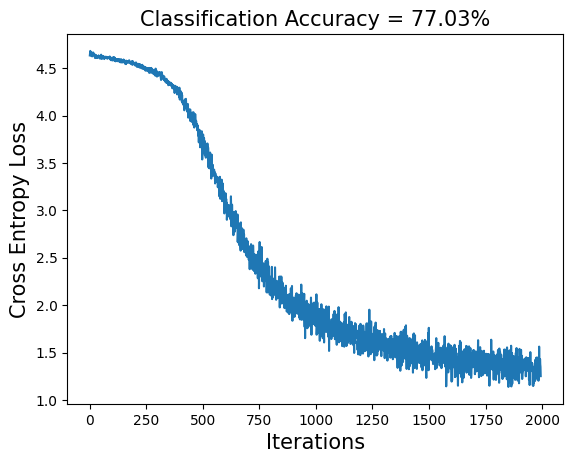

In [23]:
import numpy as np
fig, ax = plt.subplots(nrows = 1, ncols=1)
ax.plot(range(len(lossVals)),lossVals)
ax.set_xlabel('Iterations',fontsize = 15)
ax.set_ylabel('Cross Entropy Loss', fontsize = 15)
ax.set_title('Classification Accuracy = {:.2f}%'.format(accuracy),fontsize = 15)
path = 'dim_{}_accry_{:.2f}len_{}_hidden_{}'.format(dModel,accuracy, maxLen,hidden_size)
plt.savefig(path+'.pdf')

# SVM With LSTM 
### Instead of the 2 fully connected layers and 1 soft-max layer in the LSTM model above, we use multi-class SVM for classification below.

## 1) Declare LSTM model and load trained weights.

In [24]:
class w2nModelSVM(torch.nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, nClasses):
        super(w2nModelSVM, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.FC0 = nn.FC0(input_size = embedding_dim, hidden_size = hidden_size,batch_first=True)

    def forward(self, x):
        x = self.word_embeddings(x)     # output dimensions is batch size = N x sequence length x feature size
        (x,_) = self.LSTM(x)        
        x = x[:, -1, :]                 # gives two dimensional output, not three dimensional output
        return x

modelSVM = w2nModelSVM(vocab_size = vocabSize, 
                 embedding_dim = dModel,
                 hidden_size=hidden_size, nClasses = numClasses
                )
modelSVM.word_embeddings.weight.data.copy_((model.word_embeddings.weight))
modelSVM.FC0.load_state_dict(model.FC0.state_dict())

AttributeError: module 'torch.nn' has no attribute 'FC0'

## 2) Get LSTM Embeddings for Train and Test Dataset

In [14]:
numTrn = trainData.__len__()
trnEmbdngs = np.zeros((numTrn,hidden_size))
trnLbls  = []
modelSVM.eval()
for i, data in enumerate(trainLoader):
    inputs,labels_ = data
    outputs = modelSVM(inputs)
    trnEmbdngs[i*batchSize: (i+1)*batchSize,:] = outputs.detach().clone().numpy()
    trnLbls = trnLbls + [lblMap[x] for x in labels_]

numTst = testData.__len__()
tstEmbdngs = np.zeros((numTst,hidden_size))
tstLbls = [] 
for i, data in enumerate(testLoader):
    inputs,labels_ = data
    labels =  []
    outputs = modelSVM(inputs)
    tstEmbdngs = outputs.detach().clone().numpy()
    tstLbls = tstLbls + [lblMap[x] for x in labels_]

## 3) Accuracy using Linear SVM


In [ ]:
from sklearn import svm
clf = svm.SVC(decision_function_shape='ovo', kernel = 'linear')
clf.fit(trnEmbdngs, np.asarray(trnLbls))
TrnAccrcyLnr = clf.score(trnEmbdngs, np.asarray(trnLbls))
TstAccrcyLnr = clf.score(tstEmbdngs,np.asarray(tstLbls))
print(r'Train Accuracy of Linear SVM =', 100*TrnAccrcyLnr)
print(r'Test Accuracy of Linear SVM =', 100*TstAccrcyLnr)

## 4) Accuracy using RBF Kernel SVM

In [ ]:
clf = svm.SVC(decision_function_shape='ovo', kernel='rbf')
clf.fit(trnEmbdngs, trnLbls)
TrnAccrcyKrnl = clf.score(trnEmbdngs, trnLbls)
TstAccrcyKrnl = clf.score(tstEmbdngs,tstLbls)
print(r'Train Accuracy of Kernel SVM =', 100*TrnAccrcyKrnl)
print(r'Test Accuracy of Kernel SVM =', 100*TstAccrcyKrnl)